## Classification

https://dl.dropboxusercontent.com/u/75194/ac297rtut5.ipynb

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
from PIL import Image

### Risk for Classification

(diagram from Abu-Mustafa's Learning From Data Course)
![ml diagram](https://dl.dropboxusercontent.com/u/75194/abumustafa.png)

Lets define 

$$E_{XY}[f(X,Y)] = \int f(x,y) dP_{XY}(x,y) = \int f(x,y) p(x,y)\,dx\,dy$$ where $P$ is the distribution (cdf) and $p$ is the local density. We'll use the Lebesgue measure for continuous rvs and the counting measure for discrete rvs, so as to use the integral symbol everywhere.

Then consider an estimator function (for regression, estimating $f$ per usual) or action (for classification) $g$. The risk accociated with $g$ is:

$$R(g) = E_{XY}[l(g(X),Y)]$$

where $l(g(x),y)$ is the loss associated with choosing action $g$ at x when $Y=y$. For example, for regression we can use $l = (g-y)^2$ and for classification we usually use the 1-0 loss $l = \mathbb{1}_{g \ne y}$.

$g$ is typically learnt on a given dataset $D_n$, well then subscript it $g_n$ to indicate that. So in general we are interested in $R(g_n)$, and sometimes, in a frequentist outlook $E_{D_n}[g_n]$.

For the 1-0 loss, which is a measurement of simple inaccuracy in classification:

$$R(g) = E_{XY}[l(g(X),Y)] = P_{XY}(g(X) \ne Y) = \int dP_X P_{Y|X}(g(X) \ne Y | X=x)$$

Thus:

$$R(g) = \int dP_X \left( 1 - P_{Y|X}(g(X) = Y | X=x) \right).$$

If we maximize this second term at each 'point' $X=x$ we will minimize the classifcation risk. This is the Maximum-a-priori estimate, so the 1-0 loss basically maximizes the mode of a posterior.

We can also consider more general risk functions:

$$R(g) = E_x[\int dP_{Y|X} l(g(X),Y)] = \int dP_X \left(\sum_c p(c|x) l(g(x),c)\right)$$.

So if we minimize the "posterior expected loss" at each $x$ we are done. Notice that $g$ here is an action. By this we mean that its not the probabilty estimation function. It can be the prediction function. (while in regression g is the approximating function here it is just a map conveniently giving us 0's and 1's. We can even generalize to actions not in the set of possible classifications. Finally we might not choose to do the entire x integral if we are only interested in part of the sample space, such as the space corresponding to mortgage defaulters or direct-marketing conveteds.

In [2]:
df=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


###Generative Classifier

In a generative model you are usually modelling $P_{XY}$ directly, usually with some parameters $\theta$. In the example below, one can model with two multivariate gaussians, although in the diagram I am faking it with a kdeplot. [POSSIBLE DERIVATION]

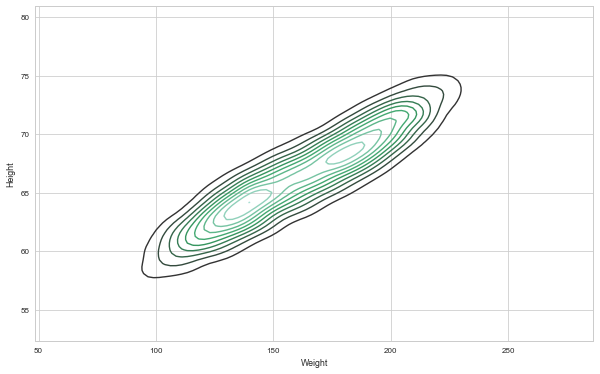

In [3]:
plt.figure(figsize=(10,6))
sns.kdeplot(df.Weight, df.Height);

In [4]:
dfdata = df[['Weight', 'Height']].values
dfresu = (df['Gender'] == "Male")*1
print dfdata.shape, dfresu.shape

(10000, 2) (10000,)


###Discriminative classifier

In a discriminative classifier like logistic regression you directly model the posterior  $P_{Y|X} = p(y| x)dy$ directly. The relationship between Logistic and a gaussian mixture model is that you tie the covariance matrices in the two groups together.

In [5]:
from sklearn.linear_model import LogisticRegression
def cv_optimize_logistic(X, y, n_folds=10):
    clf = LogisticRegression()
    parameters = {"C": [0.01, 0.1, 1, 10, 100]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs

In [6]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


def points_plot2(X, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10,6))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=0.5, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return plt.gca()

In [7]:
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
def points_plot_prob(X, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10,6))
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cm_bright, s=10, alpha=0.2)
    # and testing points
    yact=clf.predict(Xte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cm_bright, alpha=0.2, marker="s", s=10)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.2)
    cs2 = plt.contour(xx, yy, Z, cmap=cm, alpha=.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return plt.gca() 

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001) {'C': 0.01} 0.91975 [mean: 0.91975, std: 0.00915, params: {'C': 0.01}, mean: 0.91975, std: 0.00915, params: {'C': 0.1}, mean: 0.91975, std: 0.00915, params: {'C': 1}, mean: 0.91975, std: 0.00915, params: {'C': 10}, mean: 0.91975, std: 0.00915, params: {'C': 100}]


//anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


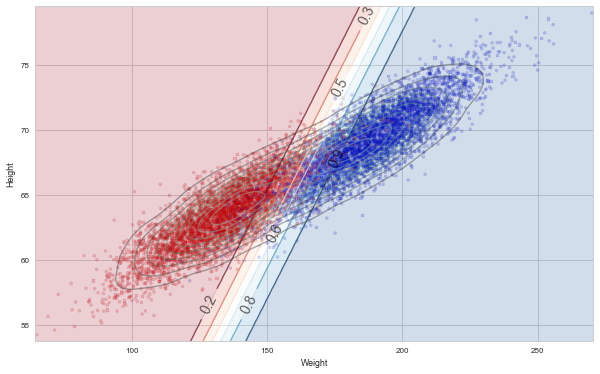

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

dftrain, dftest, resutrain, resutest = train_test_split(dfdata, dfresu, train_size=0.8)
dflogis = cv_optimize_logistic(dftrain, resutrain)
print dflogis.best_estimator_, dflogis.best_params_, dflogis.best_score_, dflogis.grid_scores_
points_plot_prob(dfdata, dftrain, dftest, resutrain, resutest, dflogis)
sns.kdeplot(df.Weight, df.Height, shade=False, alpha=0.4);

In [9]:
df[df.Gender=='Male'].cov()

,Height,Weight
Height,8.198843,48.879649
Weight,48.879649,391.294074


In [10]:
df[df.Gender!='Male'].cov()

,Height,Weight
Height,7.269947,43.576404
Weight,43.576404,361.854281


###Callibration

A classifier like Logistic regression outputs probabilities. You must check its callibration: ie the notion that a samples with probability p occur a fraction p of the time in test sets.

from Chris Beaumont's diagram in cs109 hw 3 (2013)

<img src="http://i.imgur.com/ea5B6zr.png" width=500px>

In [11]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical Fraction")

    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    #calsum = cal['count'].sum()
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    plt.xlabel("Classifier Probability")


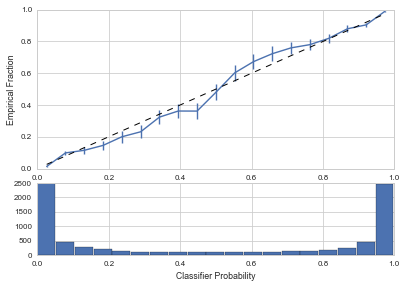

In [12]:
calibration_plot(dflogis, dftrain, resutrain)

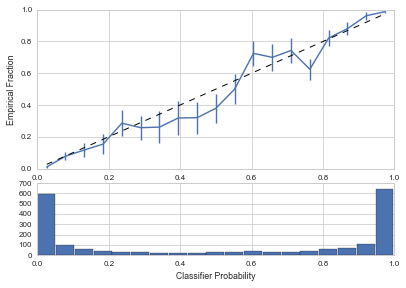

In [13]:
calibration_plot(dflogis, dftest, resutest)

###Classifier Evaluation

The confusion matrix is the basic starting point.

![confmatrix](https://dl.dropboxusercontent.com/u/75194/confmatrix.JPG)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dflogis.predict(dftest), resutest)

array([[878,  71],
       [ 94, 957]])

(from Data Science for business: Foster and Fawcwett:)

The "posterior expected loss" sets us up very nicely to evaluate classifiers based on the notion that out losses or gains should reflect our business scenario. (Note that we could have as well maximized utility or benefit instead of minimizing loss. Its the same formula.


![expectedvalue](https://dl.dropboxusercontent.com/u/75194/expectedvalue.png)

###ROC Curve

Let $p(y=1|x) > t$ mean $g(x)=1$. $t$ is the threshold. We move it from 0 to 1 and get different TPR and FPR and plot TPR against FPR.

$$TPR = Recall = \frac{TP}{ObsvP} = \frac{TP}{TP+FN}.$$

$$FPR = \frac{FP}{ObsvN} = \frac{FP}{FP+TN}$$

![howto roc](https://dl.dropboxusercontent.com/u/75194/howtoroc.png)

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
fprhw, tprhw, thresholdshw=roc_curve(resutest, dflogis.predict_proba(dftest)[:,1])
roc_auchw = auc(fprhw, tprhw)

In [18]:
print thresholdshw

[  9.99996090e-01   9.99995039e-01   9.99992241e-01 ...,   2.82408442e-05
   2.48731761e-05   1.91550691e-05]


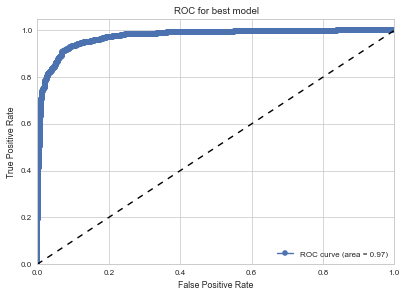

In [19]:
plt.plot(fprhw, tprhw, 'o-', label='ROC curve (area = %0.2f)' % roc_auchw)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right");

###Precision and Recall

**Recall** tells you how many of the true positives were recalled:

$$Recall = \frac{TP}{ObsvP} = \frac{TP}{TP+FN}.$$

**Precision** tells you how many of the returned hits (+ives) were truly positive

$$Precision = \frac{TP}{PredP} = \frac{TP}{TP+FP}.$$

[ 0.55778622  0.55754615  0.557849   ...,  1.          1.          1.        ] [  1.00000000e+00   9.99027237e-01   9.99027237e-01 ...,   1.94552529e-03
   9.72762646e-04   0.00000000e+00] [ 0.00172081  0.00174447  0.00177031 ...,  0.99999224  0.99999504
  0.99999609]


(0.0, 1.05)

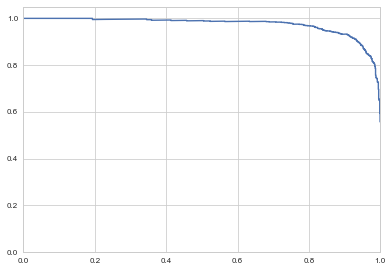

In [98]:
phw,rhw,thw = precision_recall_curve(resutest, dflogis.predict_proba(dftest)[:,1])
print phw, rhw, thw
plt.plot(rhw, phw);
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

###The ATM Camera example

In [21]:
#wget https://dl.dropboxusercontent.com/u/75194/imag.pix.npy
#wget https://dl.dropboxusercontent.com/u/75194/imag.lbl.npy
data=np.load("./imag.pix.npy")
y=np.load("./imag.lbl.npy")
STANDARD_SIZE = (322, 137)
data.shape, y.shape

((87, 132342), (87,))

In [22]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

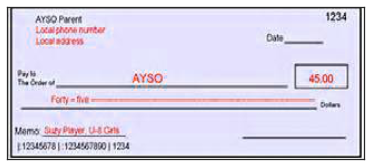

In [23]:
display_image(data[5])

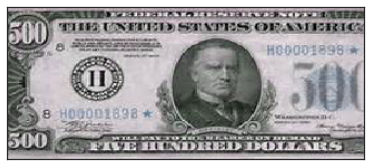

In [24]:
display_image(data[50])

### The curse of dimensionality: Feature engineering

In [25]:
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=50)
X = pca.fit_transform(data)
print pca.explained_variance_ratio_.sum()

0.905874558047


In [26]:
pca.explained_variance_ratio_

array([ 0.35925967,  0.06293188,  0.04107783,  0.0311951 ,  0.0281696 ,
        0.02288316,  0.02101279,  0.0187405 ,  0.01732646,  0.01530238,
        0.01421597,  0.01318394,  0.01247015,  0.01163818,  0.01099583,
        0.01060732,  0.0100743 ,  0.00980239,  0.00960559,  0.00915359,
        0.00901856,  0.00852133,  0.00836746,  0.00796924,  0.00754898,
        0.00725056,  0.00708218,  0.00679677,  0.00660925,  0.00647721,
        0.00627392,  0.00594773,  0.00583031,  0.00574509,  0.00572782,
        0.00552617,  0.00538587,  0.00533432,  0.00516657,  0.00493432,
        0.00485946,  0.00477622,  0.00472842,  0.004562  ,  0.00444171,
        0.00440045,  0.00434604,  0.00428004,  0.00421957,  0.00410035])

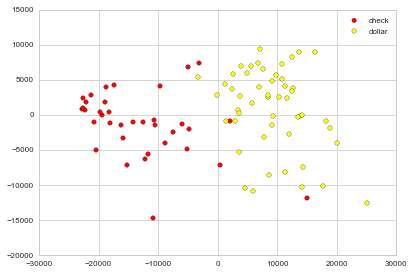

In [27]:
df = pd.DataFrame({"pc1": X[:, 0], "pc2": X[:, 1], "y":y, "label":np.where(y==1, "check", "dollar")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

In [28]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

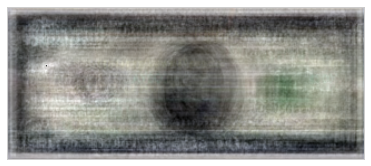

In [29]:
display_component(pca,0)

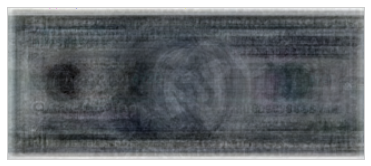

In [30]:
display_component(pca,1)

###Classifying in a reduced feature space with kNN

In [31]:
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs, warn_on_equidistant=False)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print "Accuracy on training data: %0.2f" % (training_accuracy)
        print "Accuracy on test data:     %0.2f" % (test_accuracy)
        points_plot2(Xall, Xtrain, Xtest, ytrain, ytest, clf)
    return nbrs, training_accuracy, test_accuracy

Accuracy on training data: 1.00
Accuracy on test data:     0.86


(1, 1.0, 0.8571428571428571)

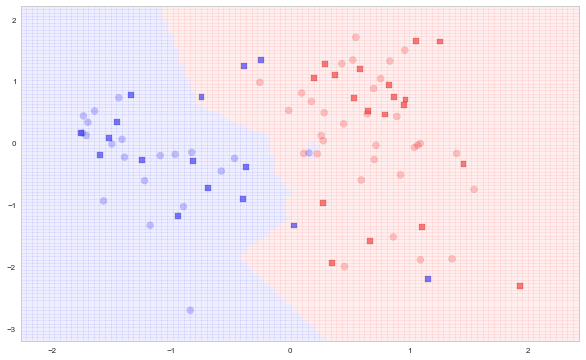

In [32]:
classify(Xs,ys,1)

Accuracy on training data: 0.62
Accuracy on test data:     0.54


(40, 0.61538461538461542, 0.54285714285714282)

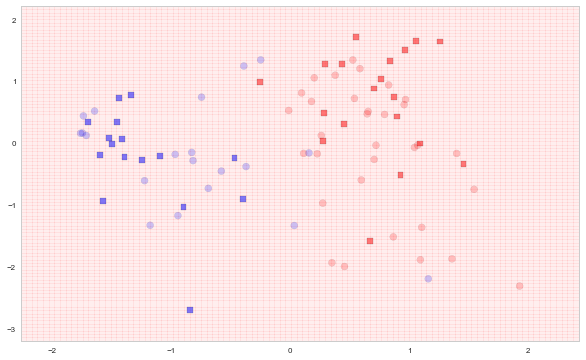

In [33]:
classify(Xs,ys,40)#run this a few times

Accuracy on training data: 0.94
Accuracy on test data:     0.94


(17, 0.94230769230769229, 0.94285714285714284)

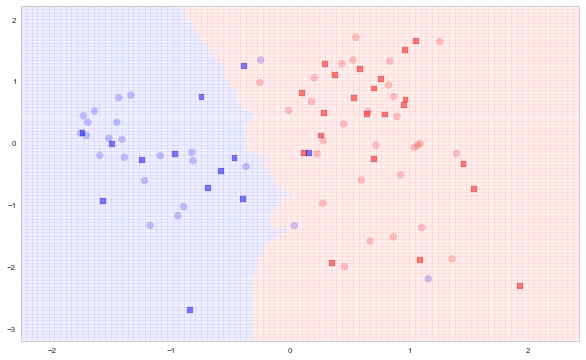

In [34]:
classify(Xs,ys,17)

###Learning Curves (against complexity)

In [35]:
fits={}
for k in np.arange(1,40,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,40,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

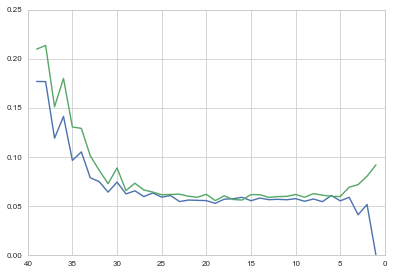

In [36]:
pal=sns.color_palette()
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=pal[0]);

plt.plot(nbrs, fmeanste, color=pal[1]);

In [37]:
def cv_optimize_knn(X, y, n_folds=10):
    clf = KNeighborsClassifier()
    parameters = {"n_neighbors": range(1,40,1)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs

In [38]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xs, ys, train_size=0.8)
bestcv = cv_optimize_knn(Xtrain, ytrain)

In [39]:
bestcv.best_estimator_, bestcv.best_params_, bestcv.best_score_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_neighbors=7, p=2, weights='uniform'),
 {'n_neighbors': 7},
 0.95652173913043481)

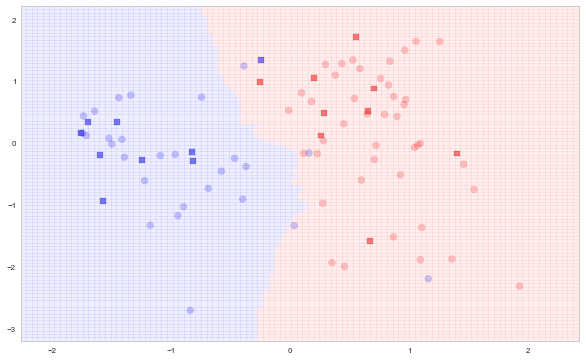

In [40]:
points_plot2(Xs, Xtrain, Xtest, ytrain, ytest, bestcv)

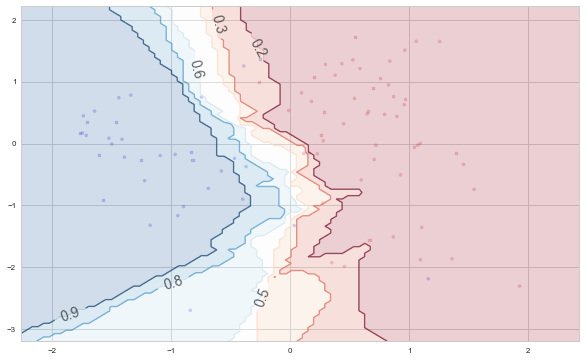

In [41]:
points_plot_prob(Xs, Xtrain, Xtest, ytrain, ytest, bestcv)

###Again, Callibration and Evaluation

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(bestcv.predict(Xtest), ytest)

array([[9, 1],
       [0, 8]])

In [43]:
print classification_report(bestcv.predict(Xtest), ytest)

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        10
          1       0.89      1.00      0.94         8

avg / total       0.95      0.94      0.94        18



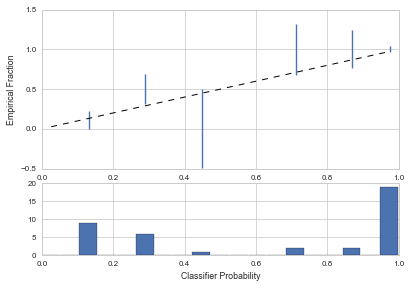

In [44]:
calibration_plot(bestcv, Xtrain, ytrain)

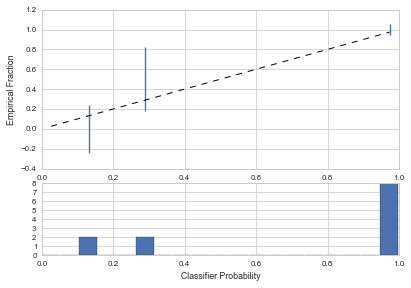

In [45]:
calibration_plot(bestcv, Xtest, ytest)

###Changing the risk function

What if the risk is asymmetric? What if the classes are assymetric? Will we do better than the base rate?

(from Data Science for business: Foster and Fawcwett:)

![abmodelcm](https://dl.dropboxusercontent.com/u/75194/abmodelcm.png)

![abmodeldiag](https://dl.dropboxusercontent.com/u/75194/abmodeldiag.png)


We can work out the math for a 2-class problem with assymmetric weights.

At each $x$, or sample:

$$R(1|x) = r_1 = l_{11} p_1 + l_{10} p_0$$

$$R(0|x) = r_0 = l_{01} p_1 + l_{00} p_0$$

We decide $g=1$ if $r_1 < r_0$ else we decide g=0. If the assymetric losses are 0 then this works out to; choose 1 iff:

$$p_0 < r p_1$$

where

$$r = \frac{l_{01}}{l_{10}} = \frac{l_{FN}}{l_{FP}}$$

In [46]:
def points_plot_asymm(X, Xtr, Xte, ytr, yte, clf, r, colorscale=cmap_light, cdiscrete=cmap_bold):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10,6))
    p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = p0 < r*p1
    print Z.sum(), Z.mean()
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=0.5, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return plt.gca()

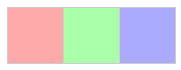

In [47]:
sns.palplot(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def make_myscorer(r):
    def my_scorer(est, X, y):
        probs=est.predict_proba(X)
        p0 = probs[:,0]
        p1 = probs[:,1]
        ypred = (p0 < r*p1)*1
        return recall_score(y, ypred)
    return my_scorer

def cv_optimize_knn_ASYMM(X, y, k, n_folds=10):
    clf = KNeighborsClassifier()
    parameters = {"n_neighbors": range(1,40,1)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=make_myscorer(k))
    gs.fit(X, y)
    return gs


In [49]:
bestcv2 = cv_optimize_knn_ASYMM(Xtrain, ytrain, 10)
bestcv2.best_estimator_, bestcv2.best_params_, bestcv2.best_score_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_neighbors=8, p=2, weights='uniform'),
 {'n_neighbors': 8},
 1.0)

7233 0.7233


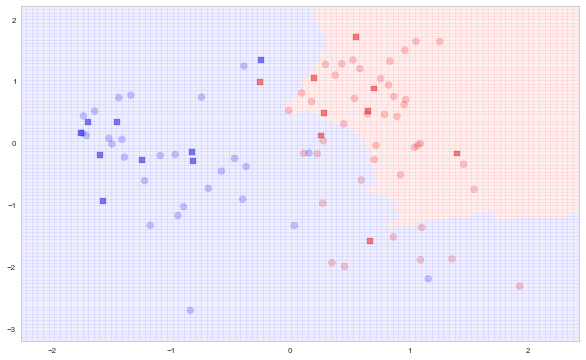

In [50]:
points_plot_asymm(Xs, Xtrain, Xtest, ytrain, ytest, bestcv2, 10)

In [51]:
def repredict(est,r, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p0 < r*p1)*1
    return ypred

In [52]:
confusion_matrix(ytest, repredict(bestcv2, 10, Xtest))

array([[6, 3],
       [0, 9]])

In [53]:
cmap3 = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmapb3 = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def points_plot_asymm3(X, Xtr, Xte, ytr, yte, clf, k0, k1, colorscale=cmap3, cdiscrete=cmapb3):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    plt.figure(figsize=(10,6))
    p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    zpred1 = (k1 < p1)*1
    zpred2 = (k0 < p1)*1
    Z =  zpred1 + zpred2
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=0.8, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return plt.gca()

###The reject option

Yet another way to think about this is to leave stuff inbetween the two classes to a human: just classify it into a third class. I'll leave the loss function formalism for you to develop.

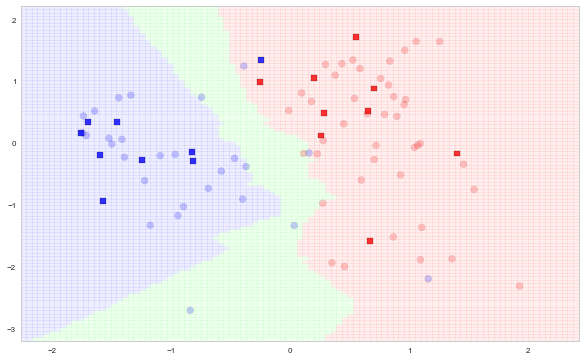

In [54]:
points_plot_asymm3(Xs, Xtrain, Xtest, ytrain, ytest, bestcv2, 0.25, 0.75)

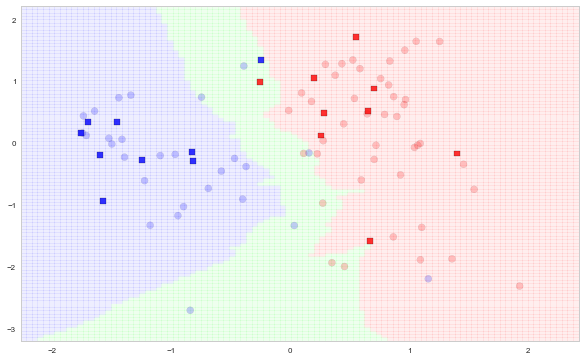

In [55]:
points_plot_asymm3(Xs, Xtrain, Xtest, ytrain, ytest, bestcv, 0.25, 0.75)

###More model evaluation and comparison

Did you do better than random? Did you do better than the base rate?

In [56]:
fpr, tpr, thresholds=roc_curve(ytest, bestcv.predict_proba(Xtest)[:,1])

In [57]:
roc_auc = auc(fpr, tpr)

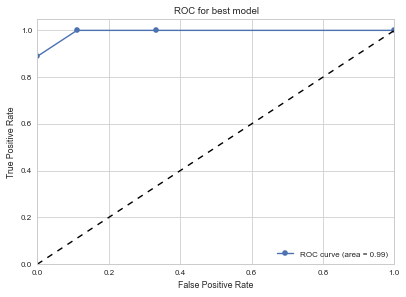

In [58]:
plt.plot(fpr, tpr, 'o-', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for best model')
plt.legend(loc="lower right");

In [65]:
print classification_report(ytest, bestcv.predict(Xtest))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95         9
          1       1.00      0.89      0.94         9

avg / total       0.95      0.94      0.94        18



In [66]:
print classification_report(ytest, repredict(bestcv2, 10, Xtest))

             precision    recall  f1-score   support

          0       1.00      0.67      0.80         9
          1       0.75      1.00      0.86         9

avg / total       0.88      0.83      0.83        18



### Comparison to another learner

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001) {'C': 0.01} 0.95652173913 [mean: 0.95652, std: 0.09431, params: {'C': 0.01}, mean: 0.94203, std: 0.09943, params: {'C': 0.1}, mean: 0.94203, std: 0.10861, params: {'C': 1}, mean: 0.94203, std: 0.10861, params: {'C': 10}, mean: 0.94203, std: 0.10861, params: {'C': 100}]


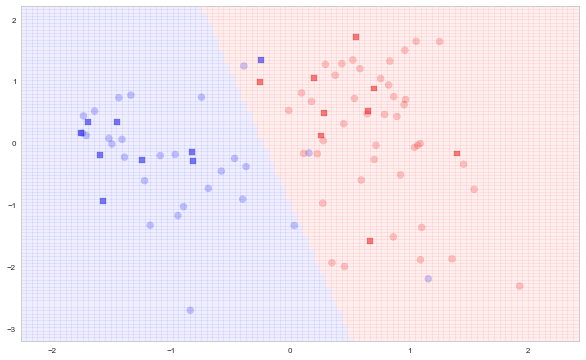

In [67]:
bestlogis = cv_optimize_logistic(Xtrain, ytrain)
print bestlogis.best_estimator_, bestlogis.best_params_, bestlogis.best_score_, bestlogis.grid_scores_
points_plot2(Xs, Xtrain, Xtest, ytrain, ytest, bestlogis)

In [68]:
fprl, tprl, thresholdsl=roc_curve(ytest, bestlogis.predict_proba(Xtest)[:,1])
roc_aucl = auc(fprl, tprl)

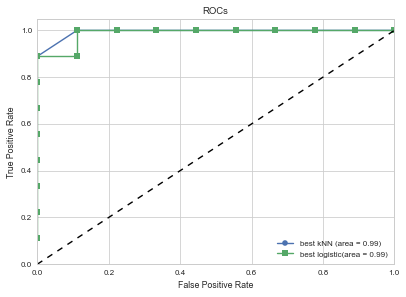

In [69]:
plt.plot(fpr, tpr, 'o-', label='best kNN (area = %0.2f)' % roc_auc)
plt.plot(fprl, tprl, 's-', label='best logistic(area = %0.2f)' % roc_aucl)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCs')
plt.legend(loc="lower right");

###SVM

from Jesse Johnson's excellent Shape of Data;
http://shapeofdata.wordpress.com/2013/05/14/linear-separation-and-support-vector-machines/


![max margin](https://dl.dropboxusercontent.com/u/75194/BDF/svm.png) 
The idea is to draw a line in space between the classes. But not any line, but the line which gives the `maximum margin` rectangle between points of different classes.

from http://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-the-linearly-separable-case-1.html :
![support vectors](https://dl.dropboxusercontent.com/u/75194/BDF/img1260.png)

The points right at the boundary are called the support vectors, which is where the name comes from.

But what if the separability is not so simple, and there are points intruding?

![intrusion](https://dl.dropboxusercontent.com/u/75194/BDF/svm21.png)

Then the idea is to minimize the distance of the "crossed over" points from the separating line. These crossed over points are costed using "slack" vectors. You dont want too many of these.

You obtain the line my minimizing the [Hinge Loss](http://en.wikipedia.org/wiki/Hinge_loss)

In [71]:
df=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/olives-cleaned.csv")
df.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


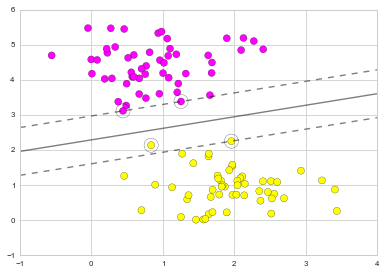

In [72]:
##Stolen from Jake's notebooks, above: https://github.com/jakevdp/ESAC-stats-2014
from IPython.html.widgets import interact
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC # "Support Vector Classifier"

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

def plot_svm(N):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

In [73]:
dfnosouth=df[df.regionstring!='South']
dfnosouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
323,Inland-Sardinia,2,5,11.29,1.20,2.22,72.72,11.12,0.43,0.98,0.02,Sardinia
324,Inland-Sardinia,2,5,10.42,1.35,2.10,73.76,11.16,0.35,0.90,0.03,Sardinia
325,Inland-Sardinia,2,5,11.03,0.96,2.10,73.80,10.85,0.32,0.94,0.03,Sardinia
326,Inland-Sardinia,2,5,11.18,0.97,2.21,72.79,11.54,0.35,0.94,0.02,Sardinia
327,Inland-Sardinia,2,5,10.52,0.95,2.15,73.88,11.26,0.31,0.92,0.01,Sardinia


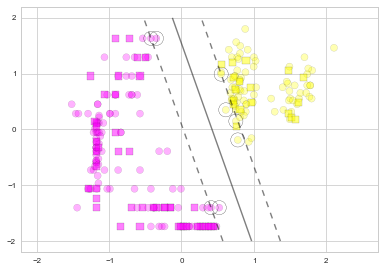

In [74]:
X = dfnosouth[['linoleic', 'arachidic']]
Xstd= (X -X.mean())/X.std()
y = (dfnosouth.regionstring.values=='Sardinia')*1
Xtrain, Xtest, ytrain, ytest = train_test_split(Xstd.values,y)
clf = SVC(kernel="linear")
clf.fit(Xtrain, ytrain)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);

In [75]:
clf.score(Xtest, ytest)

1.0

Often in SVMs one uses the [kernel trick](http://en.wikipedia.org/wiki/Kernel_method), which maps a lower dimension to a higher one to make things separable.

See (from above mentioned book)

![](https://dl.dropboxusercontent.com/u/75194/BDF/img1331.png)

So lets see what using a Radial Gaussian kernel look like?

$$e^{-\gamma d(x_1,x_2)^2}$$


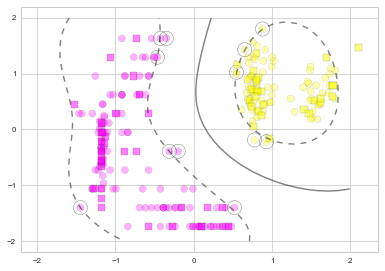

In [76]:
X = dfnosouth[['linoleic', 'arachidic']]
Xstd= (X -X.mean())/X.std()
y = (dfnosouth.regionstring.values=='Sardinia')*1
Xtrain, Xtest, ytrain, ytest = train_test_split(Xstd.values,y)
clf = SVC()
clf.fit(Xtrain, ytrain)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);

In [77]:
clf.score(Xtest, ytest)

1.0

We alluded earlier to the cost function for SVM and talked about the regularization parameter $C$.

The loss looks like

$$ C \times Misclassification Penalty + Complexity Penalty$$

If C is large, the Complexity penalty, usually $|w|^2$ is not relevant. If it is small, we get a hard margin classifier which is prone to overfitting as it is sensitive to outliers. Missclassification penalty is

$$1-t.y, y=W.x+b$$

The actual objective function that soft margin SVM tries to minimize is 
$$
\frac{1}{2}\|w\|^2+C\sum_i\max(0,1-y_i(w^\intercal x_i+b))
$$

However, for hard margin SVM, the whole objective function is just
$$
\frac{1}{2}\|w\|^2
$$

as the sign flips and the max becomes 0

In [78]:
def cv_optimize_svm(X, y, n_folds=10, num_p=50):
    #clf = SVC()
    #parameters = {"C": np.logspace(-4, 3, num=num_p), "gamma": np.logspace(-4, 3, num=10)}
    clf = SVC(kernel="linear", probability=True)
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs

def get_optim_classifier_svm(indf, inacidlist, clon, clonval):
    subdf=indf[inacidlist]
    subdfstd=(subdf - subdf.mean())/subdf.std()
    X=subdfstd.values
    y=(indf[clon].values==clonval)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
    #Xtrain, Xtest, ytrain, ytest=X,X,y,y
    fitted=cv_optimize_svm(Xtrain, ytrain)
    return fitted, Xtrain, ytrain, Xtest, ytest

In [79]:
thesvcfit, Xtr, ytr, Xte, yte = get_optim_classifier_svm(dfnosouth, ['linoleic','arachidic'],'regionstring', "Sardinia")
#thesvcfit, Xtr, ytr, Xte, yte = get_optim_classifier_binary(dfsouthns, ['palmitic','palmitoleic'],'area', 3)
thesvcfit.best_estimator_, thesvcfit.best_params_, thesvcfit.best_score_

(SVC(C=0.051794746792312073, cache_size=200, class_weight=None, coef0=0.0,
   degree=3, gamma=0.0, kernel='linear', max_iter=-1, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=False),
 {'C': 0.051794746792312073},
 1.0)

{'kernel': 'linear', 'C': 0.051794746792312073}


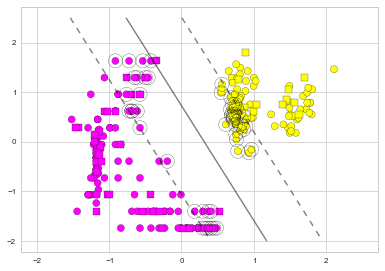

In [80]:
def plot_svm_new(clf,Xtr,ytr,Xte,yte):
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, s=50, cmap='spring')
    plt.scatter(Xte[:, 0], Xte[:, 1], marker='s', c=yte, s=50, cmap='spring')

    #plt.xlim(-1, 4)
    #plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
print dict(kernel="linear",**thesvcfit.best_params_)
clsvc=SVC(**dict(kernel="linear",**thesvcfit.best_params_)).fit(Xtr, ytr)
plot_svm_new(clsvc, Xtr, ytr, Xte, yte)

The best fit allows for a bigger margin by allowing some inbetween penalization. If we use the standard C=1 in scikit-learn you see that we are allowing for less penalization.

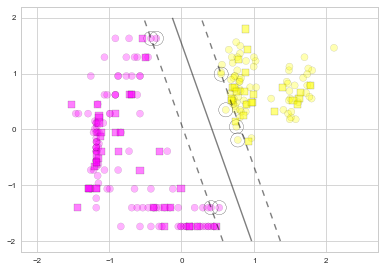

In [81]:
X=dfnosouth[['linoleic', 'arachidic']]
y = (dfnosouth.regionstring.values=='Sardinia')*1
Xstd= (X -X.mean())/X.std()
Xtrain, Xtest, ytrain, ytest = train_test_split(Xstd.values,y)
clf = SVC(kernel="linear")
clf.fit(Xtrain, ytrain)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);

And this goes super hard margin. (for more insight into all this see http://stats.stackexchange.com/questions/74499/what-is-the-loss-function-of-hard-margin-svm)

1.0


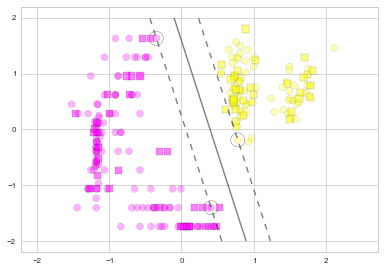

In [82]:
#X = dfsouthns[['palmitic', 'palmitoleic']]
#y = (dfsouthns.area.values==3)*1
X=dfnosouth[['linoleic', 'arachidic']]
y = (dfnosouth.regionstring.values=='Sardinia')*1
Xstd= (X -X.mean())/X.std()
Xtrain, Xtest, ytrain, ytest = train_test_split(Xstd.values,y)
clf = SVC(kernel="linear", C=100000)
clf.fit(Xtrain, ytrain)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);
print clf.score(Xtest, ytest)

###Decision Trees

Descision trees are very simple things we are all familiar with. If a problem is multi-dimensional, the tree goes dimension by dimension and makes cuts in the space to create a classifier.

![](http://scikit-learn.org/stable/_images/iris.svg)

In [83]:
def classify_tree(indf, inacidlist, clon, clf, train_size=0.6):
    subdf=indf[inacidlist]
    subdfstd=(subdf - subdf.mean())/subdf.std()
    X=subdfstd.values
    y=indf[clon].values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

In [84]:
#from Jake's ESAC notebook
def visualize_tree(estimator, Xtr, ytr, Xte, yte, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(Xtr, ytr)

    if xlim is None:
        xlim = (Xtr[:, 0].min() - 0.1, Xtr[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (Xtr[:, 1].min() - 0.1, Xtr[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), ytr.max())

    # Plot also the training points
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, s=50, cmap='rainbow')
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte, s=50, marker='s', cmap='rainbow')

    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(ytr.min(), ytr.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

In [85]:
from sklearn.tree import DecisionTreeClassifier
dfsouth=df[df.regionstring=='South']
dfsouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


Accuracy on training data: 1.00
Accuracy on test data:     0.76


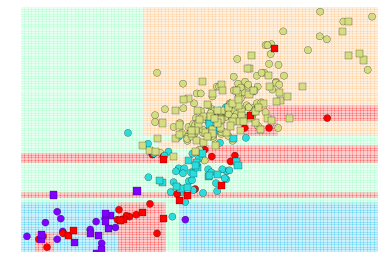

In [86]:
clf = DecisionTreeClassifier()
clf, xtr, ytr, xte, yte = classify_tree(dfsouth, ['palmitic','palmitoleic'], 'area', clf)
visualize_tree(clf, xtr, ytr, xte, yte, boundaries=False)

One critical byproduct we get from trees is feature importances--FEATURE SELECTION (but if u r cross-validating remember to do this inside each cval fold!!!!!)

In [87]:
zip(['palmitic','palmitoleic'],clf.feature_importances_)

[('palmitic', 0.24216194605531904), ('palmitoleic', 0.75783805394468107)]